In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

#TODO: this should be 224 if we want to use mobilenet
target_shape = (224, 224)

In [2]:
##load the dataset


In [3]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [4]:
# Load images into arrays
import pathlib

#specify a maximum how many pair that can be made pr class (value is for both positive and negative pairs )

def load_images(path):
    img_array_data = []
    data_dir = pathlib.Path(path)
    image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
    folders = [x for x in data_dir.iterdir() if x.is_dir()]
    for i, folder in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(folder.iterdir()):
        
            img_array_data[i].append(img)
            
    return img_array_data


def load_images_v2(path):
    data_dir = os.listdir(path)
    img_array_data = []
    
    folders = data_dir#[x for x in data_dir]
    for i, dir_path in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(os.listdir(path + "/"+dir_path)):
        
            img_array_data[i].append(path + "/"+dir_path+"/"+img)
            
    return img_array_data





#test_data = load_images("./data/tiered_imagenet/test")

#val_data = load_images("./data/tiered_imagenet/val")


def get_anchor_and_positives(images, max_pairs, max_pairs_per_class):
    anchor_images, positive_images = [],  []
    should_break = False
    should_terminate = False
    
    for i, array in enumerate(images):
        if(should_terminate):
            print("Terminating with a class count of: ", i-1)
            break
        for j in range(len(array)-1):
            if(should_break):
                should_break = False
                break
            
            for k in range(len(array)-1):
            
                
                
               
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: ", (i+1)*(j+1)*(k+1))
                    should_terminate = True
                    should_break = True
                    break
                if((j+1)*(k+1) >= max_pairs_per_class):
                    should_break = True
                    break                
                
    if(not should_terminate):
        print("Terminating with a class count of: ", str(len(images)))         
    return anchor_images, positive_images

def get_anchor_positives_negatives(images, max_pairs):
    anchor_images, positive_images, negative_images = [], [], []

    should_terminate = False

    for i, array in enumerate(images):
        if(should_terminate):
            break
        for j in range(len(array)-1):
            if(should_terminate):
                break
            for k in range(len(array)-1):
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                negative_images.append(images[(i + 1)%len(images)][k % len(images[(i + 1)%len(images)])])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: " + str(len(anchor_images)))
                    should_terminate = True
                    break
    return anchor_images, positive_images, negative_images


#anchor_images, positive_images = get_anchor_n_positives(test_data)
#anchor_images, positive_images = get_anchor_n_positives(val_data)



#print("train samples: ", len(train_data))
#print("validation samples: ",len(val_data))
#print("test samples: ", len(test_data))

#unison_shuffled_copies(train_data, train_labels)
#unison_shuffled_copies(test_data, test_labels)
#unison_shuffled_copies(val_data, val_labels)

In [5]:
base_path = "data/dataset_pairs"

data = (load_images_v2(base_path))
# data.extend(load_images_v2(base_path+"/test"))
print("Maximum Available Classes: " + str(len(data)))
anchor_images, positive_images = get_anchor_and_positives(data, 3000, 10)
pair_count = len(anchor_images)
print(pair_count)


Maximum Available Classes: 50
Terminating with a class count of:  50
405


In [6]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(len(list(dataset)) * 0.8))
val_and_test = dataset.skip(round(len(list(dataset)) * 0.8))
val_dataset = val_and_test.take(round(len(list(val_and_test)) * 0.5))
test_dataset = val_and_test.skip(round(len(list(val_and_test)) * 0.5))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

test_dataset = test_dataset.batch(32, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)

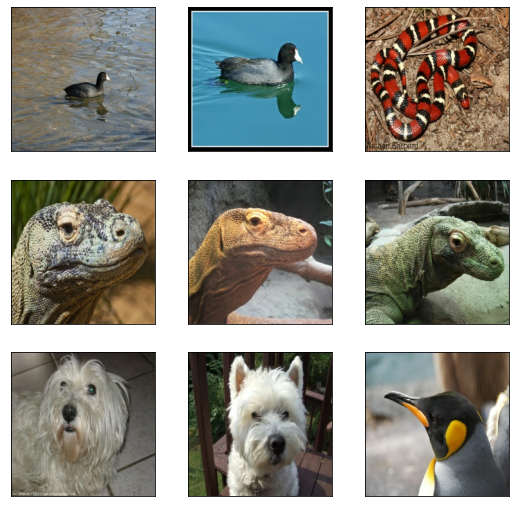

In [7]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [8]:
#TODO: this should be mobilenet

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, BatchNormalization, Input, Layer, Dropout
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

embedding_extractor = Sequential(name='embedding')
base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=target_shape + (3,))
base_cnn.trainable = False
embedding_extractor.add(base_cnn)
embedding_extractor.add(Dense(128, activation='relu'))
embedding_extractor.add(Dropout(0.5))
embedding_extractor.add(Dense(64, activation='relu'))
embedding_extractor.add(GlobalAveragePooling2D())


# embedding.add(BatchNormalization())
# embedding.add(Dense(128, activation='relu'))

# base_cnn = MobileNetV2(
#     weights="imagenet", input_shape=target_shape + (3,), include_top=False
# )

# #TODO: consider using anohter flattening layer
# flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(256, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(256)(dense2)

# embedding = Model(base_cnn.input, output, name="Embedding")

# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable

In [9]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding_extractor((anchor_input)),
    embedding_extractor((positive_input)),
    embedding_extractor((negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [10]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=1):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [11]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=Adam())
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
11/11 [==============================] - 14s 807ms/step - loss: 0.2456 - val_loss: 0.1317
Epoch 2/10
11/11 [==============================] - 7s 657ms/step - loss: 0.1164 - val_loss: 0.0655
Epoch 3/10
11/11 [==============================] - 7s 666ms/step - loss: 0.0566 - val_loss: 0.1091
Epoch 4/10
11/11 [==============================] - 7s 668ms/step - loss: 0.0508 - val_loss: 0.0000e+00
Epoch 5/10
11/11 [==============================] - 7s 668ms/step - loss: 0.1253 - val_loss: 0.2327
Epoch 6/10
11/11 [==============================] - 8s 674ms/step - loss: 0.1393 - val_loss: 0.0000e+00
Epoch 7/10
11/11 [==============================] - 7s 667ms/step - loss: 0.0828 - val_loss: 0.1092
Epoch 8/10
11/11 [==============================] - 7s 652ms/step - loss: 0.1649 - val_loss: 0.0134
Epoch 9/10
11/11 [==============================] - 7s 664ms/step - loss: 0.0667 - val_loss: 0.0752
Epoch 10/10
11/11 [==============================] - 8s 673ms/step - loss: 0.0457 - val_los

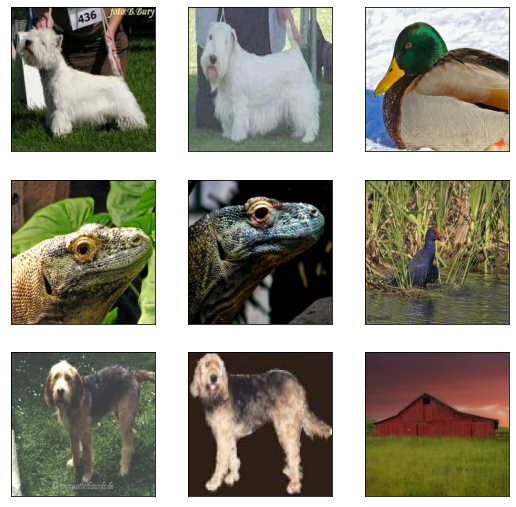

In [12]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_extractor((anchor)),
    embedding_extractor((positive)),
    embedding_extractor((negative)),
)

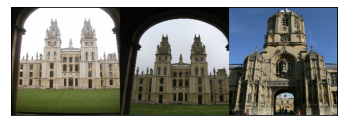

Pos Similarity: 0.9530868
Neg Similarity: 0.9269564


In [13]:
import util

test_img2 = preprocess_image('data/dataset/all_souls/all_souls_000006.jpg')
test_img3 = preprocess_image('data/dataset/all_souls/all_souls_000140.jpg')
test_img4 = preprocess_image('data/dataset/christ_church/christ_church_000996.jpg')

em = embedding_extractor(np.expand_dims(test_img2, axis=0))
em2 = embedding_extractor(np.expand_dims(test_img3, axis=0))
em3 = embedding_extractor(np.expand_dims(test_img4, axis=0))

cosine_similarity = metrics.CosineSimilarity()

util.visualize_images(test_img2, test_img3, test_img4)

pos = cosine_similarity(em, em2)
neg = cosine_similarity(em, em3)
print("Pos Similarity:", str(pos.numpy()))
print("Neg Similarity:", str(neg.numpy()))

In [14]:
sim_list = []

folders = util.load_images('data/dataset_pairs')
data, labels = util.create_pairs(folders)
data, labels = util.shuffle_data(data, labels)
data_split, labels_split = util.split_data(data, labels)
data_train, data_val, data_test = data_split
labels_train, labels_val, labels_test = labels_split

for i in range(len(data_test)):
    features_1 = embedding_extractor.predict(np.expand_dims(data_test[i][0], axis=0))
    features_2 = embedding_extractor.predict(np.expand_dims(data_test[i][1], axis=0))

    sim = util.cosine_similarity(features_1, features_2)
    sim_list.append(sim)

Total amount of images: 354


Best accuracy: 0.9722222222222222
triplet
- Amount of TP: 35
- Amount of TN: 35
- Amount of FP: 1
- Amount of FN: 1
- AUC score: 0.9945987654320988
- Accuracy: 0.9722222222222222
- Recall: 0.9722222222222222
- Precision: 0.9722222222222222
- F1: 0.9722222222222222
- Kappa: 0.9444444444444444


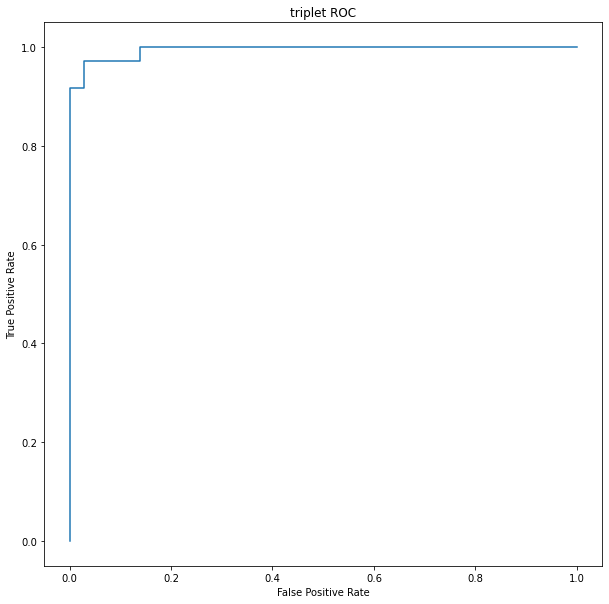

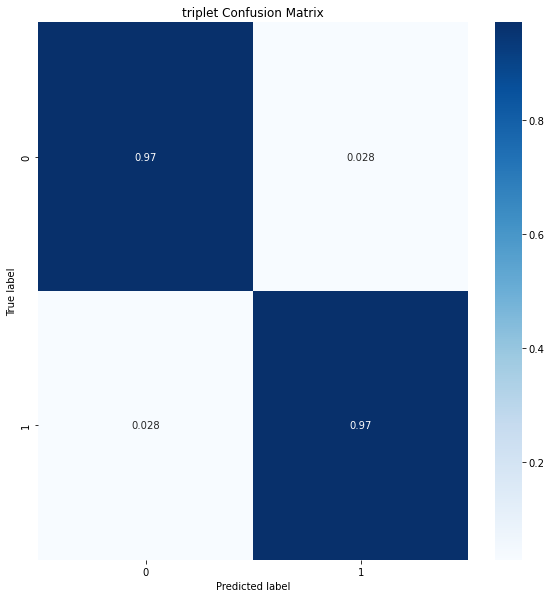

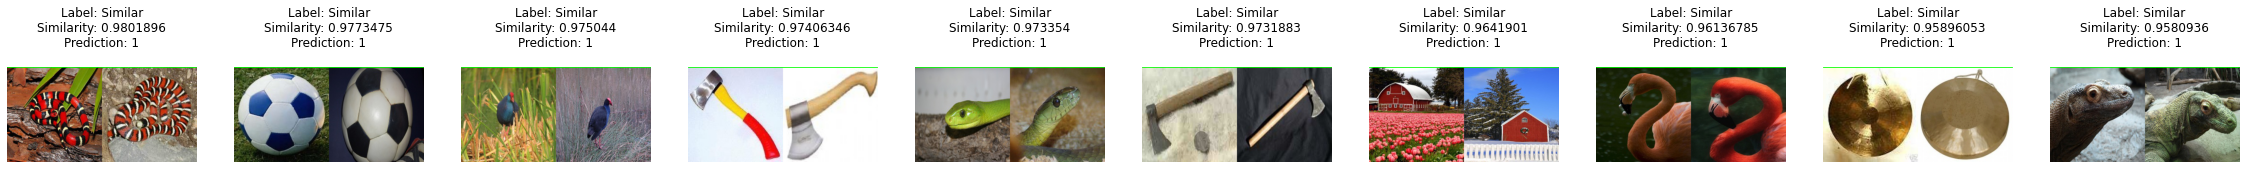

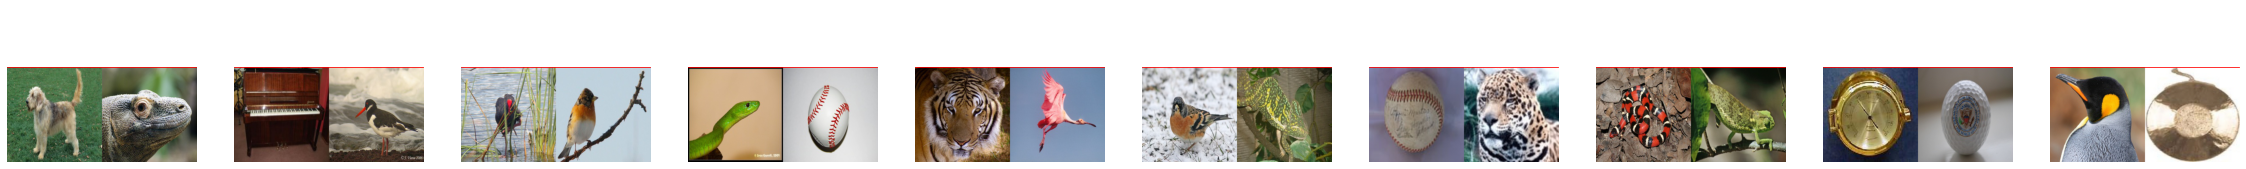

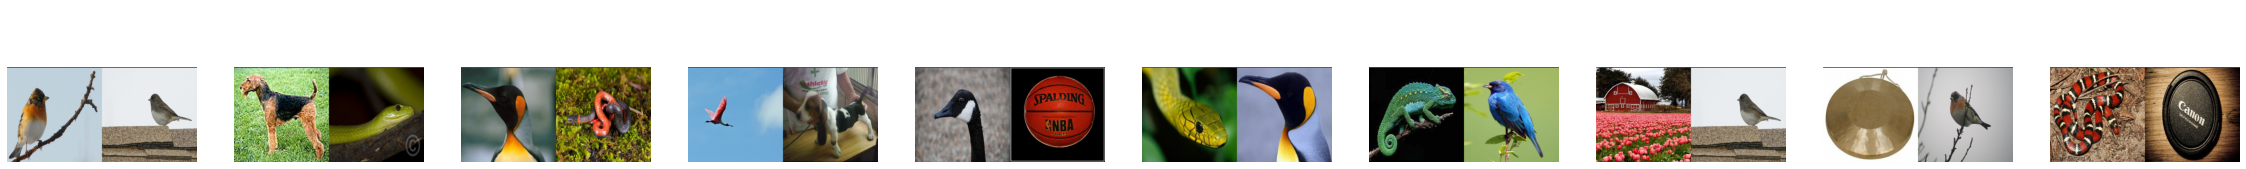

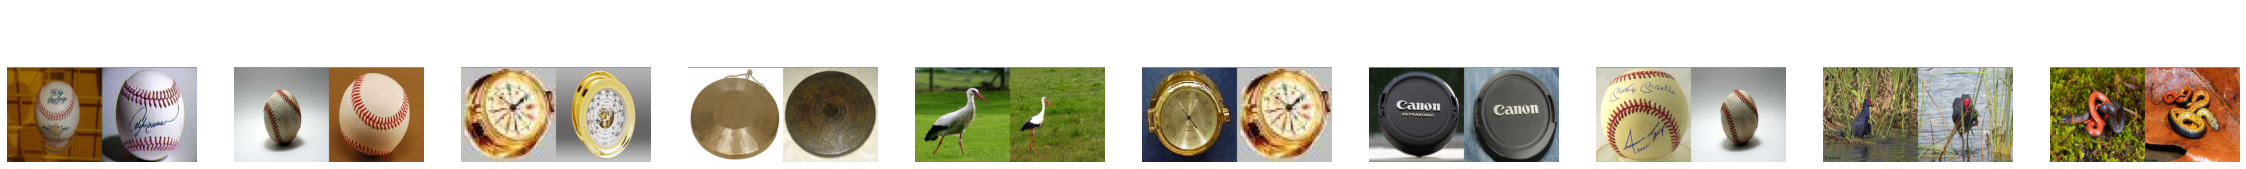

Threshold:  0.7650000000000006


In [15]:
util.evaluate(data=data_test, labels=labels_test, similarity=sim_list, name="triplet")

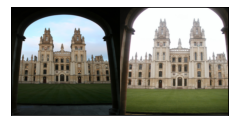

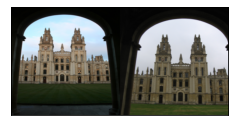

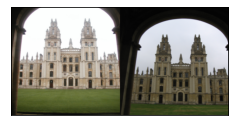

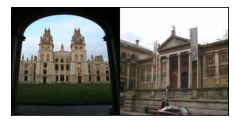

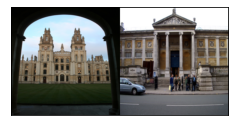

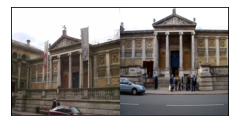

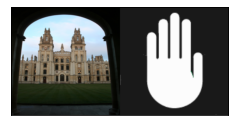

0.9353314
0.9258364
0.9517648
0.87904584
0.9047324
0.9432988
0.888856


In [16]:
test_img1 = util.load_image_norm('data/dataset/all_souls/all_souls_000002.jpg')
test_img2 = util.load_image_norm('data/dataset/all_souls/all_souls_000006.jpg')
test_img3 = util.load_image_norm('data/dataset/all_souls/all_souls_000140.jpg')
test_img4 = util.load_image_norm('data/dataset/ashmolean/ashmolean_000002.jpg')
test_img5 = util.load_image_norm('data/dataset/ashmolean/ashmolean_000000.jpg')
test_img6 = util.load_image_norm('test_image_1.png')

test_img1_features = embedding_extractor.predict(test_img1)
test_img2_features = embedding_extractor.predict(test_img2)
test_img3_features = embedding_extractor.predict(test_img3)
test_img4_features = embedding_extractor.predict(test_img4)
test_img5_features = embedding_extractor.predict(test_img5)
test_img6_features = embedding_extractor.predict(test_img6)

sim1 = util.cosine_similarity(test_img1_features, test_img2_features)
sim2 = util.cosine_similarity(test_img1_features, test_img3_features)
sim3 = util.cosine_similarity(test_img2_features, test_img3_features)
sim4 = util.cosine_similarity(test_img1_features, test_img4_features)
sim5 = util.cosine_similarity(test_img1_features, test_img5_features)
sim6 = util.cosine_similarity(test_img4_features, test_img5_features)
sim7 = util.cosine_similarity(test_img1_features, test_img6_features)

util.visualize_images(test_img1[0], test_img2[0])
util.visualize_images(test_img1[0], test_img3[0])
util.visualize_images(test_img2[0], test_img3[0])
util.visualize_images(test_img1[0], test_img4[0])
util.visualize_images(test_img1[0], test_img5[0])
util.visualize_images(test_img4[0], test_img5[0])
util.visualize_images(test_img1[0], test_img6[0])

print(sim1)
print(sim2)
print(sim3)
print(sim4)
print(sim5)
print(sim6)
print(sim7)

In [17]:
# embedding_extractor.save('models/embeddings/triplet_loss_embedding_extractor.h5')

In [18]:
# !tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 models/embeddings/triplet_loss_embedding_extractor.h5 models/embeddings/triplet_loss_embedding_extractor.tfjs